## Financial Derivatives


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from dateutil.relativedelta import *
from datetime import date, datetime, timedelta

In [2]:
notional = 1748653.15
start = "19-01-2007"
end = "19-01-2022"
#interest = Euribor 6M, half-yearly, act/360, modified following, adjusted

### Import data

In [3]:
data = pd.read_csv('./HA_swaps.csv', index_col=0)
swaption_vols = pd.read_csv('./HA_swaptionNormalVol.csv').pivot('Expiry', 'Tenor', 'NormalVol')
cap_vols = pd.read_csv('./HA_capNormalVol.csv').pivot('Tenor','Strike','NormalVol')

### Interest Rates

In [4]:
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
data = data[data.columns[:-2]].dropna() #Swap 40Y and 50Y are not needed as have many MV
data.sort_index(inplace=True)
data

,Deposit 6M,FRA 1X7,FRA 2X8,FRA 3X9,FRA 4X10,FRA 5X11,FRA 6X12,FRA 7X13,FRA 8X14,FRA 9X15,...,Swap 7Y,Swap 8Y,Swap 9Y,Swap 10Y,Swap 11Y,Swap 12Y,Swap 15Y,Swap 20Y,Swap 25Y,Swap 30Y
2007-01-02,3.857,3.9285,3.9770,4.0155,4.0455,4.0755,4.0975,4.0965,4.1010,4.1005,...,4.1175,4.1335,4.1520,4.1720,4.1870,4.2060,4.2445,4.2840,4.2750,4.2590
2007-01-03,3.860,3.9170,3.9720,4.0145,4.0410,4.0670,4.0820,4.0870,4.0920,4.0890,...,4.1155,4.1325,4.1505,4.1715,4.1885,4.2045,4.2580,4.2845,4.2950,4.2635
2007-01-04,3.865,3.9315,3.9865,4.0225,4.0435,4.0720,4.0915,4.0975,4.1025,4.0985,...,4.1110,4.1255,4.1445,4.1625,4.1815,4.1985,4.2455,4.2755,4.2780,4.2565
2007-01-05,3.864,3.9415,3.9950,4.0410,4.0710,4.0950,4.1220,4.1305,4.1365,4.1325,...,4.1525,4.1695,4.1875,4.2055,4.2235,4.2405,4.2885,4.3175,4.3290,4.2970
2007-01-08,3.874,3.9435,4.0015,4.0435,4.0695,4.0985,4.1225,4.1215,4.1275,4.1235,...,4.1485,4.1665,4.1860,4.2060,4.2260,4.2420,4.2885,4.3200,4.3210,4.3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-14,-0.522,-0.5340,-0.5285,-0.5320,-0.5385,-0.5410,-0.5410,-0.5430,-0.5460,-0.5560,...,-0.4250,-0.3835,-0.3405,-0.2965,-0.2550,-0.2130,-0.1180,-0.0425,-0.0395,-0.0675
2020-12-15,-0.520,-0.5225,-0.5320,-0.5315,-0.5360,-0.5375,-0.5380,-0.5400,-0.5430,-0.5500,...,-0.4190,-0.3800,-0.3370,-0.2920,-0.2500,-0.2110,-0.1130,-0.0340,-0.0320,-0.0600
2020-12-16,-0.525,-0.5185,-0.5180,-0.5180,-0.5190,-0.5220,-0.5210,-0.5240,-0.5240,-0.5300,...,-0.3940,-0.3525,-0.3070,-0.2640,-0.2220,-0.1810,-0.0845,-0.0073,-0.0050,-0.0325
2020-12-17,-0.518,-0.5160,-0.5170,-0.5160,-0.5180,-0.5190,-0.5170,-0.5190,-0.5240,-0.5300,...,-0.3960,-0.3550,-0.3110,-0.2660,-0.2235,-0.1820,-0.0820,0.0000,0.0033,-0.0230


### Setup Market Data

In [5]:
# function to complete tenors. For instance, in the data we have 15Y and 20Y tenor
# This function adds the tenors in between: 16Y, 17Y, 18Y, 19Y
def getalltenors(rates):
    rates = rates.copy()
    swapTenors = [*map(lambda x: int(re.search(r'\d*(?=Y)',x).group()), rates.filter(like = 'Swap', axis=0).index)]
    swapRates = rates.filter(like = 'Swap', axis=0).values
    
    for tenor in range(min(swapTenors), max(swapTenors)+1):
        idx = f'Swap {tenor}Y'
        if not idx in rates.index:
            rates.loc[idx] = np.interp(tenor, swapTenors,swapRates)
            
    def yearFrac(idx):
        if '6M' in idx:
            return 0.5
        if 'FRA' in idx:
            return int(re.search('(?<=X)\d*',idx).group()) / 12
        if 'Swap' in idx:
            return int(re.search('(?<=Swap )\d*', idx).group())
            
    sortedIndex=sorted(rates.index, key=yearFrac)
    return rates.loc[sortedIndex]

## 1. What are the estimated cash flows of this loan on the 15th of January of 2007?

In [6]:
from scipy.interpolate import interp1d

class SwapCurve:
    def __init__(self, dt):
        self.rates = getalltenors(data.loc[dt])
        self.refDate = datetime.strptime(dt, '%Y-%m-%d').date() if type(dt) == str else dt.date()
        self.bootstrap()
        
    #Get the date correspondent to that tenor.
    def tenorDate(self, tenor):
        timep = tenor[-1]
        if timep =='M':
            months = int(tenor[:-1])
            return (self.refDate+ relativedelta(months=months))
        elif timep == 'Y':
            years = int(tenor[:-1])
            return (self.refDate + relativedelta(years=years))
    
    # Put data in appropriate format    
    def strToDate(self, dt):
        if type(dt) == str:
            dt = datetime.strptime(dt, '%Y-%m-%f').date()
        return dt
    
    # Make cash flow schedule.
    def makeSchedule(self, start, end, freq=6): 
        start = datetime.strptime(start, "%Y-%m-%d").date() if isinstance(start, str) else start
        end = datetime.strptime(end, "%Y-%m-%d").date() if isinstance(end, str) else end
        def advance(dt, months):
            if months == 12: 
                try:
                    return date(dt.year + int(months/12), dt.month, dt.day)
                except:
                    return date(dt.year + int(months/12), dt.month, dt.day-1)
            try:
                return date(dt.year, dt.month + months, dt.day)
            except:
                return date(dt.year + 1, dt.month - months, dt.day)
        dates = [start]
        while dates[-1] <= end:
            dates.append(advance(dates[-1], freq))
        return dates[:-1]

    # Compute the discount factor
    def df(self, date):
        date = self.strToDate(date)
        x = (date - self.refDate).days
        if x<0:
            return 0
        
        return np.exp(np.interp(x,self.curve.days.values.astype(int),np.log(self.curve.df.values.astype(float))))
    
    # Compute the day count fraction
    def fwd(self,start,end):
        if self.strToDate(start) < self.refDate:
            return data.loc[:str(start)].iloc[-2]['Deposit 6M'] / 100
        
        df0 = self.df(start)
        df1 = self.df(end)
        dcf = (self.strToDate(end) - self.strToDate(start)).days/360
        return (df0/df1 -1)/dcf
    
    #Bootstrap the swap zero-curve
    def bootstrap(self):

        curve = pd.DataFrame(columns = ['maturity', 'days', 'parRate', 'df'])

        curve.loc['refDate', 'days'] = 0
        curve.loc['refDate', 'maturity'] = self.refDate
        curve.loc['refDate', 'df'] = 1.000000

        for tenor, rate in self.rates.items():
            parRate = rate/100
            if '6M' in tenor:
                curve.loc[tenor, 'maturity'] = self.tenorDate("6M")
                days = (self.tenorDate("6M") - self.refDate).days
                curve.loc[tenor, 'days'] = days
                curve.loc[tenor, 'parRate'] = parRate
            elif 'Y' in tenor:
                curve.loc[tenor, 'maturity'] = self.tenorDate(re.search('(?<=Swap )\d*', tenor).group() + "Y")
                days = (self.tenorDate(re.search('(?<=Swap )\d*', tenor).group() + "Y") - self.refDate).days
                curve.loc[tenor, 'days'] = days
                curve.loc[tenor, 'parRate'] = parRate

            elif 'X' in tenor:
                curve.loc[tenor, 'maturity'] = self.tenorDate(str(int(re.search('(?<=X)\d*',tenor).group())) + "M")
                days = (self.tenorDate(str(int(re.findall(r'\d+', tenor)[1])) + "M") - self.refDate).days
                curve.loc[tenor, 'days'] = days
                curve.loc[tenor, 'parRate'] = parRate
 
        #Calc DF of the instruments
        for idx, row in curve.iterrows():
            if 'Deposit' in idx:
                dcf = (row.maturity - self.refDate).days / 360
                curve.loc[idx, 'df'] = 1 / (1+row.parRate * dcf)
            elif "FRA" in idx:
                x = curve[~curve.df.isna()].maturity.apply(datetime.toordinal).values
                y = curve[~curve.df.isna()].df
                
                f = interp1d(x, y, kind='linear', fill_value="extrapolate")
                
                date0 = row.maturity + relativedelta(months=-6)
                dcf = (row.maturity - date0).days / 360
                
                df0 = f(date0.toordinal())
                
                df1 = df0/(1+row.parRate * dcf)
                curve.loc[idx, 'df'] = df1
            elif "Swap" in idx:
                prev_dates = self.makeSchedule(self.refDate, row.maturity, 12)[1:-1]
                x = curve[~curve.df.isna()].maturity.apply(datetime.toordinal).values
                y = curve[~curve.df.isna()].df
                f = interp1d(x, y, kind='linear', fill_value="extrapolate")
                prev_dfs = sum([f(dt.toordinal()) for dt in prev_dates])
                curve.loc[idx, 'df'] = (1 - row.parRate * prev_dfs) / (1 + row.parRate)

        self.curve = curve
                     
crv = SwapCurve('2007-01-15')
crv.bootstrap()
crv.curve

,maturity,days,parRate,df
refDate,2007-01-15,0,NaN,1.0
Deposit 6M,2007-07-15,181,0.0388,0.980865
FRA 1X7,2007-08-15,212,0.03952,0.977304
FRA 2X8,2007-09-15,243,0.04026,0.973726
FRA 3X9,2007-10-15,273,0.040659,0.970428
FRA 4X10,2007-11-15,304,0.041048,0.967026
FRA 5X11,2007-12-15,334,0.041386,0.963761
FRA 6X12,2008-01-15,365,0.041543,0.960472
FRA 7X13,2008-02-15,396,0.041606,0.956954
FRA 8X14,2008-03-15,425,0.041689,0.953627


In [7]:
#Class Leg serves as "Support" to classes Floatingleg and fixed Leg. it defines characteristics that will then be used in those 
#Classes 
class Leg:
    def __init__(self, notional, start, maturity, freq=6, dayCounter = 'Act/360'):
        self.notional = notional
        self.start = start
        self.maturity = maturity
        self.dates = self.schedule(start, maturity, freq)
        cfs = pd.DataFrame()
        cfs['start'] = self.dates[:-1]
        cfs['end'] = self.dates[1:]
        if dayCounter == 'Act/360':
            cfs['dcf'] = cfs.apply(lambda x: (x.end - x.start).days / 360, axis = 1)
        else:
            cfs['dcf'] = 1 if freq == 12 else 0.5
        cfs['notional'] = notional
        self.cfs = cfs
        
      #Define leg cash flow schedule    
    def schedule(self, start, end, freq=6):
        roll_date = end.day
        def advance(dt,months):
            tmp = dt + timedelta(days=int(months * 30.5))
            new_date = date(tmp.year, tmp.month, roll_date)
            while new_date.weekday() > 4:
                new_date += timedelta(days=1)
            return new_date
        dates = [start]
        while dates[-1] <= end:
            dates.append(advance(dates[-1], freq))
        return dates[:-1]
    
    # Compute PV01
    def pv01(self):
        return (self.cfs.notional * self.cfs.dcf * 0.0001 * self.cfs.df).sum()
    
    # Compute leg's present value
    def npv(self):
        return (self.cfs.interest * self.cfs.df).sum()
    
    # Format data frame (number of decimal places etc.)
    def display_df(self):
        return self.cfs.style.format({'notional':'{:,.2f}', 'interest': '{:,.2f}',
                                      'cashflow': '{:,.2f}', 'rate': '{:,.3%}', 
                                      'dcf': '{:,.3f}', 'df': '{:,.5f}'})

class FloatingLeg(Leg):
    def __init__(self, notional, start, maturity, curve, freq=6, dayCounter='Act/360'):
        super().__init__(notional, start, maturity, freq, dayCounter)
        self.cfs['rate'] = self.cfs.apply(lambda x: curve.fwd(x.start, x.end), axis=1)
        self.cfs['interest'] = self.cfs.notional * self.cfs.dcf * self.cfs.rate
        self.cfs['df'] = self.cfs.end.apply(curve.df)


In [8]:
notional = 1_748_653.15
start = date(2007,1,19)
maturity = date(2022,1,19)
crv = SwapCurve('2007-01-15')

loan = FloatingLeg(notional, start, maturity, crv)
loan.cfs.rename(columns={'interest':'cashflow'}, inplace=True)
loan.cfs.loc[loan.cfs.index[-1], 'cashflow'] += notional
loan.display_df()

,start,end,dcf,notional,rate,cashflow,df
0,2007-01-19,2007-07-19,0.503,"1,748,653.15",3.889%,"34,187.94",0.98041
1,2007-07-19,2008-01-21,0.517,"1,748,653.15",4.157%,"37,559.35",0.95979
2,2008-01-21,2008-07-21,0.506,"1,748,653.15",4.127%,"36,480.68",0.94018
3,2008-07-21,2009-01-19,0.506,"1,748,653.15",4.091%,"36,164.79",0.92113
4,2009-01-19,2009-07-20,0.506,"1,748,653.15",4.080%,"36,072.14",0.90251
5,2009-07-20,2010-01-19,0.508,"1,748,653.15",4.081%,"36,273.38",0.88417
6,2010-01-19,2010-07-19,0.503,"1,748,653.15",4.085%,"35,917.19",0.86637
7,2010-07-19,2011-01-19,0.511,"1,748,653.15",4.087%,"36,526.03",0.84865
8,2011-01-19,2011-07-19,0.503,"1,748,653.15",4.123%,"36,249.87",0.83141
9,2011-07-19,2012-01-19,0.511,"1,748,653.15",4.125%,"36,869.77",0.81424


## 2. Consider that company wants to hedge its' interest rate risk with an Interest Rate Swap.

### 2. (a) What would be the details of the swap with an annual fixed rate 30/360 in order to have a perfect hedge?

In [9]:
from scipy.optimize import root

class FixedLeg(Leg):
    def __init__(self, notional, start, maturity, curve, fixedRate, freq=12, dayCounter = '30/360'):
        super().__init__(notional, start, maturity, freq, dayCounter)
        self.cfs['rate'] = (len(self.dates)-1)*[fixedRate,]
        self.cfs['interest'] = self.cfs.notional * self.cfs.dcf * self.cfs.rate
        self.cfs['df'] = self.cfs.end.apply(curve.df)
    
class Swap():
    def __init__(self, notional, start, maturity, crv, fixedRate):
        self.notional = notional
        self.crv = crv
        self.start = start
        self.maturity = maturity
        self.fixedRate = fixedRate
        self.fixedLeg = FixedLeg(notional, start, maturity, crv, fixedRate)
        self.floatingLeg = FloatingLeg(notional, start, maturity, crv)
        
    def npv(self):
        return self.floatingLeg.npv() - self.fixedLeg.npv()
    
    def updateCurve(self, curve):
        self.fixedLeg = FixedLeg(self.notional, self.start, self.maturity, curve, self.fixedRate)
        self.floatingLeg = FloatingLeg(self.notional, self.start, self.maturity, curve)
    
    def updateFixedRate(self, fixedRate):
        self.fixedRate = fixedRate
        self.fixedLeg = FixedLeg(self.notional, self.start, self.maturity, self.crv, fixedRate)
        
    def fairRate(self):
        floatLegPV = self.floatingLeg.npv()
        fixedLeg = self.fixedLeg.cfs
        return floatLegPV / (fixedLeg.notional *  fixedLeg.dcf * fixedLeg.df).sum()
   

In [10]:
crv = SwapCurve('2007-01-15')

simpleSwap = Swap(notional, start, maturity, crv, 0.0)
fixedRate = simpleSwap.fairRate()

print(f"Swap Fair Rate: {fixedRate:.4%}")
#4.3753

Swap Fair Rate: 4.3753%


In [11]:
simpleSwap.updateFixedRate(fixedRate)
simpleSwap.fixedLeg.display_df()

,start,end,dcf,notional,rate,interest,df
0,2007-01-19,2008-01-21,1.000,"1,748,653.15",4.375%,"76,508.55",0.95979
1,2008-01-21,2009-01-19,1.000,"1,748,653.15",4.375%,"76,508.55",0.92113
2,2009-01-19,2010-01-19,1.000,"1,748,653.15",4.375%,"76,508.55",0.88417
3,2010-01-19,2011-01-19,1.000,"1,748,653.15",4.375%,"76,508.55",0.84865
4,2011-01-19,2012-01-19,1.000,"1,748,653.15",4.375%,"76,508.55",0.81424
5,2012-01-19,2013-01-21,1.000,"1,748,653.15",4.375%,"76,508.55",0.78045
6,2013-01-21,2014-01-20,1.000,"1,748,653.15",4.375%,"76,508.55",0.74814
7,2014-01-20,2015-01-19,1.000,"1,748,653.15",4.375%,"76,508.55",0.71640
8,2015-01-19,2016-01-19,1.000,"1,748,653.15",4.375%,"76,508.55",0.68569
9,2016-01-19,2017-01-19,1.000,"1,748,653.15",4.375%,"76,508.55",0.65587


In [12]:
simpleSwap.floatingLeg.display_df()

,start,end,dcf,notional,rate,interest,df
0,2007-01-19,2007-07-19,0.503,"1,748,653.15",3.889%,"34,187.94",0.98041
1,2007-07-19,2008-01-21,0.517,"1,748,653.15",4.157%,"37,559.35",0.95979
2,2008-01-21,2008-07-21,0.506,"1,748,653.15",4.127%,"36,480.68",0.94018
3,2008-07-21,2009-01-19,0.506,"1,748,653.15",4.091%,"36,164.79",0.92113
4,2009-01-19,2009-07-20,0.506,"1,748,653.15",4.080%,"36,072.14",0.90251
5,2009-07-20,2010-01-19,0.508,"1,748,653.15",4.081%,"36,273.38",0.88417
6,2010-01-19,2010-07-19,0.503,"1,748,653.15",4.085%,"35,917.19",0.86637
7,2010-07-19,2011-01-19,0.511,"1,748,653.15",4.087%,"36,526.03",0.84865
8,2011-01-19,2011-07-19,0.503,"1,748,653.15",4.123%,"36,249.87",0.83141
9,2011-07-19,2012-01-19,0.511,"1,748,653.15",4.125%,"36,869.77",0.81424


### 2. (b) What would be the PV01 of the swap?

In [13]:
leg = FixedLeg(notional, start, maturity, crv, 0.0001)
leg.cfs.df.sum() * 0.0001 * notional

1903.4805327434085

In [14]:
pv01 = FixedLeg(notional, start, maturity, crv, 0.0001)
print(f"Swap PV01:{pv01.npv()}")
pv01.display_df()

Swap PV01:1903.4805327434083


,start,end,dcf,notional,rate,interest,df
0,2007-01-19,2008-01-21,1.000,"1,748,653.15",0.010%,174.87,0.95979
1,2008-01-21,2009-01-19,1.000,"1,748,653.15",0.010%,174.87,0.92113
2,2009-01-19,2010-01-19,1.000,"1,748,653.15",0.010%,174.87,0.88417
3,2010-01-19,2011-01-19,1.000,"1,748,653.15",0.010%,174.87,0.84865
4,2011-01-19,2012-01-19,1.000,"1,748,653.15",0.010%,174.87,0.81424
5,2012-01-19,2013-01-21,1.000,"1,748,653.15",0.010%,174.87,0.78045
6,2013-01-21,2014-01-20,1.000,"1,748,653.15",0.010%,174.87,0.74814
7,2014-01-20,2015-01-19,1.000,"1,748,653.15",0.010%,174.87,0.71640
8,2015-01-19,2016-01-19,1.000,"1,748,653.15",0.010%,174.87,0.68569
9,2016-01-19,2017-01-19,1.000,"1,748,653.15",0.010%,174.87,0.65587


### 2. (c) What would be the price of this swap considering that the counterparty charges 5bps from the fair value?

In [15]:
crv = SwapCurve('2007-01-15')
simpleSwap = Swap(notional, start, maturity, crv, 0.0)

In [16]:
xrate_a0 = simpleSwap.fairRate()
simpleSwap.fairRate()

0.04375284402392353

In [17]:
atmRate = simpleSwap.fairRate()
charge = 0.0005

print(f"Fair value of the swap:{atmRate:.4%}")
finalRate = atmRate + charge
print(f"Final Price:{finalRate:.4%}")
simpleSwap.updateFixedRate(atmRate + charge)

Fair value of the swap:4.3753%
Final Price:4.4253%


### 2. (d) At the trade date, what is the market value of this swap?

In [18]:
simpleSwap.fixedLeg.display_df()

,start,end,dcf,notional,rate,interest,df
0,2007-01-19,2008-01-21,1.000,"1,748,653.15",4.425%,"77,382.88",0.95979
1,2008-01-21,2009-01-19,1.000,"1,748,653.15",4.425%,"77,382.88",0.92113
2,2009-01-19,2010-01-19,1.000,"1,748,653.15",4.425%,"77,382.88",0.88417
3,2010-01-19,2011-01-19,1.000,"1,748,653.15",4.425%,"77,382.88",0.84865
4,2011-01-19,2012-01-19,1.000,"1,748,653.15",4.425%,"77,382.88",0.81424
5,2012-01-19,2013-01-21,1.000,"1,748,653.15",4.425%,"77,382.88",0.78045
6,2013-01-21,2014-01-20,1.000,"1,748,653.15",4.425%,"77,382.88",0.74814
7,2014-01-20,2015-01-19,1.000,"1,748,653.15",4.425%,"77,382.88",0.71640
8,2015-01-19,2016-01-19,1.000,"1,748,653.15",4.425%,"77,382.88",0.68569
9,2016-01-19,2017-01-19,1.000,"1,748,653.15",4.425%,"77,382.88",0.65587


In [19]:
print(f"Swap NPV:{simpleSwap.npv():,.2f}")

Swap NPV:-9,517.40


### e) Consider that today is 18th of December 2020 and calculate the historic daily market value of the swap (from 31.01.2007 to 30.11.2020)

In [20]:
res = pd.DataFrame()

for dt in data.loc['2007-01-31':'2020-11-30'].index:
    crv = SwapCurve(dt)
    simpleSwap.updateCurve(crv)
    res.loc[dt, 'Mark to Market'] = simpleSwap.npv()
    res.loc[dt, 'Swap 15Y'] = data.loc[dt, 'Swap 15Y']
    

res.head(10).style.format({"Mark to Market": "{:,.2f}"})


,Mark to Market,Swap 15Y
2007-01-31 00:00:00,-95.97,4.427800
2007-02-01 00:00:00,"-2,150.50",4.417000
2007-02-02 00:00:00,"-6,731.53",4.393000
2007-02-05 00:00:00,"-11,848.61",4.366000
2007-02-06 00:00:00,"-15,785.76",4.345500
2007-02-07 00:00:00,"-17,128.91",4.339000
2007-02-08 00:00:00,"-13,593.39",4.358000
2007-02-09 00:00:00,"-5,146.47",4.403000
2007-02-12 00:00:00,"-1,953.80",4.420000
2007-02-13 00:00:00,142.33,4.432000


### 2. (f) Make a plot of the Market Value of this swap and the market rate of the 15y swap (market value in Euros on the left axis and swap rate in % in the right axis). Comment on the reason(s) for lines to diverge.

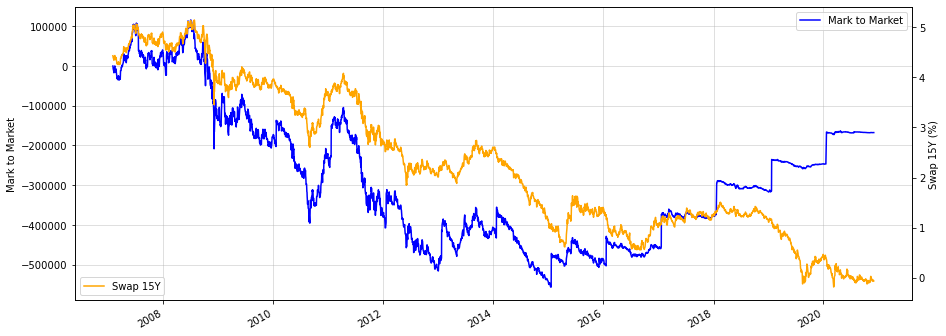

In [21]:
ax = res['Mark to Market'].plot(figsize = (15,6), c="blue")
ax.grid(alpha=0.5)
ax2 = plt.twinx()
res['Swap 15Y'].plot(ax=ax2, c ='orange')
ax.set_ylabel('Mark to Market') 
ax2.set_ylabel('Swap 15Y (%)')
ax.legend(loc="upper right")
ax2.legend(loc = "lower left");

##Comment on 2. f):

Generally there are some possible reasons for the lines to diverge:

1.Interest rate changes: If the interest rate environment changes, the market value of an existing swap will change, and the market rate for new swaps of similar maturity will also change. If the direction of the interest rate change is different for the existing swap and the new swaps, the lines on the plot will diverge. This started to happen at the end of 2018 when the interest rate start to invert the upwards trend;

2.Credit risk: If one of the parties to the swap experiences a change in their creditworthiness, it can affect the market value of the swap. The market rate for new swaps with similar counterparty risk will also change, causing the lines to diverge;

3.Market liquidity: If the market for interest rate swaps becomes more or less liquid, it can impact the market value of existing swaps and the market rate for new swaps, leading to diverging lines on the plot;

4.Changes in the yield curve: If the shape of the yield curve changes, it can impact the market value of both existing and new interest rate swaps, causing the lines on the plot to diverge.

### 2. (g) Show a table for each of the swap legs with the future cashflows considering that today is the 18th of December 2020

In [22]:
crv = SwapCurve('2020-12-18')
simpleSwap.updateCurve(crv)

aux = simpleSwap.floatingLeg.cfs
aux[aux.end > date(2020,12,18)]

,start,end,dcf,notional,rate,interest,df
27,2020-07-20,2021-01-19,0.508333,1748653.15,-0.003510,-3120.034383,1.000463
28,2021-01-19,2021-07-19,0.502778,1748653.15,-0.005156,-4533.489320,1.003063
29,2021-07-19,2022-01-19,0.511111,1748653.15,-0.005151,-4603.420300,1.005711


In [23]:
aux = simpleSwap.fixedLeg.cfs
aux[aux.end > date(2020,12,18)]

,start,end,dcf,notional,rate,interest,df
13,2020-01-20,2021-01-19,1,1748653.15,0.044253,77382.875099,1.000463
14,2021-01-19,2022-01-19,1,1748653.15,0.044253,77382.875099,1.005711


## Swaption Volatilities

## 3.  An Investment bank offered the following alternative products for the hedge:
- Alt. 1 - Company pays fixed rate X% annual 30/360 vs Euribor 6M but the bank has the right to cancel the swap after 10 years
- Alt. 2 - Company pays fixed rate X% annual 30/360 vs Euribor 6M, and sells a cap @ 6%
- Alt. 3 - Company receives Euribor 6M and pays Euribor 6M capped @ 6% and floored @ X%

### 3. (a)  Describe the details of the derivative that is being offered and determine the X in each case so that the derivative is at fair value.

In [24]:
# Alternative 1
# Can be seen as a portfolio of the Swap plus selling a 10y15y payer Swaption (for the last 5 years of the Swap),
#  with strike = fixed rate of 15y swap.

In [25]:
from scipy.optimize import root
from scipy.stats import norm

In [26]:
# 15y Swap deal details
notional = 1_748_653.15
start = date(2007,1,19)
maturity = date(2022,1,19)
crv_a1 = SwapCurve('2007-01-15')
original_swap = Swap(notional, start, maturity, crv_a1, 0.0)
original_swap.updateFixedRate(original_swap.fairRate())

dts = original_swap.fixedLeg.dates[-5:] # get dates of last 5 years

dfs = original_swap.floatingLeg.cfs[["end","df"]] # all dfs in swap schedule
dfs = dfs[dfs['end'].isin(dts)]['df'].values # array of dfs needed for the swaption

swapRate = ([dfs[0] - dfs[-1]] / np.sum(dfs[1:]))[0]
print(f"ATM Swap Rate: {swapRate:.4%}")

ATM Swap Rate: 4.6290%


In [27]:
def SwaptionPrice(dfs, expiry, normalVol, swapRate, notional, strike):
    '''
        Payer Swaption Price Using Bachelier Model
    '''
    A = sum(dfs[1:])
    T = expiry
    d = (swapRate - strike)/(normalVol * np.sqrt(T))

    swaption_price_pct = A * ((swapRate - strike)*norm.cdf(d) + normalVol * np.sqrt(T) * norm.pdf(d))

    return notional*swaption_price_pct

In [28]:
# Portfolio of Swap + Selling Payer Swaption for last 5y of contract
expiry = "15Yr"
tenor = "10Yr"
swaptionNormalVol_data = pd.read_csv("HA_swaptionNormalVol.csv")
normalVol = swaptionNormalVol_data.pivot("Expiry","Tenor","NormalVol").loc[expiry,tenor] / 10000

expiry_yrs = 15

a1_swap = Swap(notional, start, maturity, crv_a1, 0.0) #initialize swap object

def portfolioPV(fixed_rate):
    a1_swap.updateFixedRate(fixed_rate)
    return a1_swap.npv() - SwaptionPrice(dfs, expiry_yrs, normalVol, swapRate, notional, strike=fixed_rate)

xrate_a1 = root(portfolioPV, 0.0).x

print(f"Company pays {float(xrate_a1):.4%} fixed rate for Swap cancellable by bank after 10 years.")

Company pays 3.5643% fixed rate for Swap cancellable by bank after 10 years.


In [29]:
# Alternative 2

In [30]:
cap_vols = pd.read_csv('./HA_capNormalVol.csv').pivot('Tenor','Strike','NormalVol')
cap_vols

Strike,-1.00%,0.00%,1.00%,1.50%,2.00%,2.50%,3.00%,3.50%,4.00%,5.00%,6.00%,7.00%
Tenor,,,,,,,,,,,,
10Yr,103.68,84.11,91.57,94.95,96.60,98.86,100.86,102.76,104.61,108.02,111.24,114.20
12Yr,98.79,80.37,91.44,95.10,96.76,99.04,101.11,102.98,104.84,108.34,111.51,114.60
15Yr,94.17,76.83,91.04,95.00,96.79,99.16,101.25,103.16,105.05,108.55,111.85,114.91
1Yr,284.76,229.50,174.68,147.73,119.09,106.91,105.70,106.44,107.52,109.92,112.34,114.73
20Yr,88.49,72.26,89.59,93.97,96.09,98.64,100.85,102.86,104.80,108.37,111.67,114.72
25Yr,82.27,67.04,87.50,92.32,94.78,97.54,99.90,102.01,104.03,107.66,110.96,113.97
2Yr,190.45,153.05,133.39,119.77,107.47,106.07,106.12,106.90,107.93,109.37,111.57,113.78
30Yr,74.57,60.53,84.69,90.03,92.88,95.90,98.45,100.70,102.82,106.53,109.83,112.81
3Yr,158.78,127.60,105.37,96.90,95.21,97.33,99.33,101.23,103.01,106.25,121.51,111.92


In [31]:
from scipy.stats import norm

maturity = date(2022,1,19)
crv_a2 = SwapCurve('2007-01-15')
swap_a2 = Swap(notional, start, maturity, crv_a2, 0.0)

dates = crv_a2.makeSchedule(start, maturity)
notional = 1_748_653.15
strike = 0.06
strike2 = '6.00%'
tenor = '15Yr'

blackVol = cap_vols.loc[ tenor,  strike2]/100

a2_Cap = pd.DataFrame({
    'start': dates[:-1],
    'end'  : dates[1:],
    'notional': notional,
    'strike': strike
})

a2_Cap['dcf'] = a2_Cap.apply(lambda row: (row.end - row.start).days / 360, axis=1)
a2_Cap['df'] = a2_Cap.end.apply(crv_a2.df)
a2_Cap['fwd'] = a2_Cap.apply(lambda row: crv_a2.fwd(row.start, row.end), axis=1)
a2_Cap['N'] = a2_Cap.start.apply(lambda x: (x - start).days / 365)

a2_Cap['d1'] = ( np.log(a2_Cap.fwd / strike) + 0.5 * blackVol**2 * a2_Cap.N ) / (blackVol * np.sqrt(a2_Cap.N))
a2_Cap['d2'] = a2_Cap.d1 - blackVol * np.sqrt(a2_Cap.N)
a2_Cap['caplet'] = a2_Cap.notional * a2_Cap.dcf * a2_Cap.df * (a2_Cap.fwd * norm.cdf(a2_Cap.d1) - strike * norm.cdf(a2_Cap.d2))


capPrice = a2_Cap.caplet.sum() / notional

a2_Cap.style.format("{:,.2f}", subset=['caplet', 'notional']).format("{:.3%}", subset=['fwd', 'strike'])

def swap_capPv(rate):
    fxd = swap_a2.fixedLeg
    fixed_leg_pv = (fxd.notional * fxd.cfs.dcf * fxd.cfs.df * rate).sum()
    float_leg_pv = (a2_Cap.caplet * a2_Cap.df).sum()
    return fixed_leg_pv - float_leg_pv

fixedRate = swap_a2.fairRate()

swap_capPv(fixedRate)
res = root(swap_capPv, 0)
res['x'][0]
xrate_a2 = res['x'][0]

print(f"Company pays {xrate_a2:.4%} fixed rate")

Company pays 2.2148% fixed rate


In [32]:
#Alternative 3 - Alt. 3 - Company receives Euribor 6M and pays Euribor 6M capped @ 6% and floored @ X%

In [33]:
# Portfolio long cap with strike of 6% and short floor of X% (collar)

In [34]:
a3_fltleg = FloatingLeg(notional=1_748_653.15, start=date(2007,1,19), maturity=date(2022,1,19), curve=SwapCurve('2007-01-15'))

In [35]:
def capPrice():
    '''
        Cap Price Using Bachelier Model
    '''
    refDate = date(2007,1,15)
    curve_a3=SwapCurve('2007-01-15')
    
    normalVol = pd.read_csv("HA_capNormalVol.csv").pivot("Tenor","Strike","NormalVol").loc["15Yr","6.00%"] / 10000
    
    notional = 1_748_653.15
    
    dates = a3_fltleg.dates

    strike = 0.06
    cap = pd.DataFrame({
        'start': dates[:-1],
        'end'  : dates[1:],
        'notional': notional,
        'strike': strike
    })

    cap['dcf'] = cap.apply(lambda row: (row.end - row.start).days / 360, axis=1)
    cap['df'] = cap.end.apply(curve_a3.df)
    cap['fwd'] = cap.apply(lambda row: curve_a3.fwd(row.start, row.end), axis=1)
    cap['N'] = cap.start.apply(lambda x: (x - refDate).days / 365)

    cap['d'] = (cap.fwd - strike) / (normalVol * np.sqrt(cap.N))
    cap['caplet'] = cap.notional * cap.dcf * cap.df * ((cap.fwd - strike) * norm.cdf(cap.d) 
                                        + normalVol * np.sqrt(cap.N) * norm.pdf(cap.d))

    return cap.caplet.sum()

In [36]:
def floorPrice(strike):
    '''
        Floor Price Using Bachelier Model
    '''
    refDate = date(2007,1,15)
    curve_a3=SwapCurve('2007-01-15')
    maturity = "15Yr"
    
    normalVol_data = pd.read_csv("HA_capNormalVol.csv").pivot("Tenor","Strike","NormalVol").loc[maturity,] / 10000
    # convert strike from string to float
    normalVol_data.index = [float(s[:-1])/100 for s in normalVol_data.index]
    
    normalVol = np.interp(strike, normalVol_data.index, normalVol_data.values)
    
    notional = 1_748_653.15
    
    dates = a3_fltleg.dates

    floor = pd.DataFrame({
        'start': dates[:-1],
        'end'  : dates[1:],
        'notional': notional,
        'strike': (len(dates)-1)*[strike,]
    })

    floor['dcf'] = floor.apply(lambda row: (row.end - row.start).days / 360, axis=1)
    floor['df'] = floor.end.apply(curve_a3.df)
    floor['fwd'] = floor.apply(lambda row: curve_a3.fwd(row.start, row.end), axis=1)
    floor['N'] = floor.start.apply(lambda x: (x - refDate).days / 365)

    floor['d'] = (floor.fwd - strike) / (normalVol * np.sqrt(floor.N))
    floor['floorlet'] = floor.notional * floor.dcf * floor.df * ((strike - floor.fwd) * norm.cdf(-floor.d) 
                                        + normalVol * np.sqrt(floor.N) * norm.pdf(floor.d))

    return floor.floorlet.sum()

In [37]:
def portfolioPV_a3(floor_strike):
    return floorPrice(floor_strike) - capPrice()

xrate_a3 = float(root(portfolioPV_a3, 0.0).x)
print(f"Floor must have strike of {xrate_a3:.4%}.")

Floor must have strike of 2.9919%.


### 3. (b) Which one would you choose (There are no wrong choices)? Please justify your answer

We must consider the following factors:

- Market conditions: The current and expected future market conditions for interest rates, swaption and cap volumes, and other relevant market data will play a key role in determining the fair value of each alternative.

- Hedging objectives: The company should consider what it is trying to achieve with the hedge and how each alternative aligns with these goals. For example, if the company is looking to minimize its exposure to interest rate risk, Alternative 3, which involves a cap and floor, may be the most appropriate choice.

- Counterparty risk: The company should consider the creditworthiness of the investment bank offering the alternatives and assess the risk of counterparty default.

- Costs and fees: The company should consider the costs and fees associated with each alternative, including the upfront costs, ongoing fees, and any costs associated with early termination.

Nonetheless, assuming the same transaction costs for all alternatives, the best alternative also depends on its outlook regarding the evolution of interest rates. For example, if it wants to hedge against high interest rates (above 6%), the collar option (alternative 3) might be the best strategy to follow. If it wants to pay the lowest possible rate and thinks the rates are not going above 6%, then alternative 2 might be the best strategy. Alternative 1 is cheaper than the simple swap, since it incorporates selling a payer swaption which allows the bank to cancel the Swap after 10y. However, no option offers a full hedge as the simple swap of 15 years.

### 3. (c) Plot on the same graph the rate that the company would pay in each of the 4 alternatives (simple swap, and the 3 additional alternatives) for each value of Euribor 6M fixing between 0 and 10% (derivative rate on y axis and Euribor fixing on x axis)

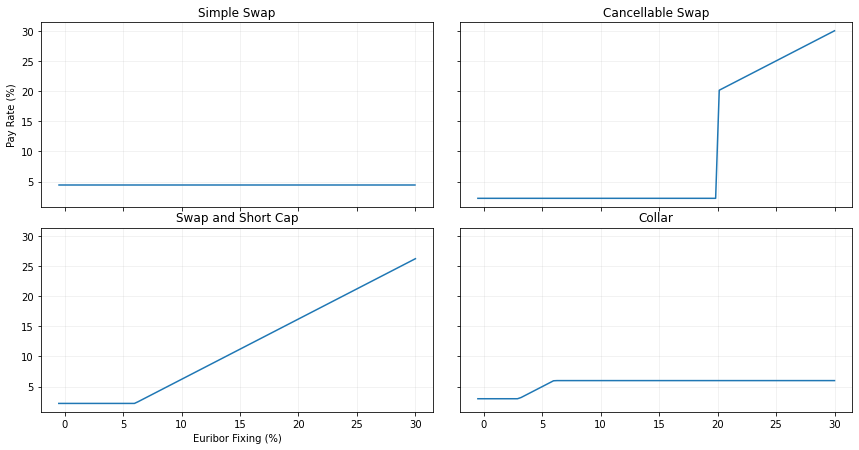

In [42]:
fig, ax = plt.subplots(2,2, figsize=(12,6), sharex=True, sharey=True)
ax = ax.flatten()
plt.tight_layout()
ax[0].set_ylabel('Pay Rate (%)'), ax[2].set_xlabel('Euribor Fixing (%)');
for a in ax: a.grid(alpha=0.2)

X = np.linspace(-0.5, 30, num=100)

swapRate = xrate_a0*100
ax[0].plot(X, [swapRate] * len(X));
ax[0].set_title('Simple Swap')

swapRate = xrate_a2*100
y = [swapRate + max(x-swapRate, 0) if x>=20 else swapRate for x in X]
ax[1].plot(X, y)
ax[1].set_title('Cancellable Swap')

swapRate = xrate_a2*100
capStrike = 0.06*100
y = [swapRate + max(x-capStrike, 0) for x in X]
ax[2].plot(X, y)
ax[2].set_title('Swap and Short Cap')

capStrike = 0.06*100
floorStrike = xrate_a3*100
y = [x - max(x-capStrike, 0) + max(floorStrike - x, 0) for x in X]
ax[3].plot(X, y)
ax[3].set_title('Collar');